In [3]:
using Pkg
Pkg.add("TestImages"); Pkg.add("Images");  Pkg.add("Colors")
using Knet, Random, IterTools, Base.Iterators, Images, Colors

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [2]:
function mask!(a,pad)
    x,y = size(a)
    for i = 1:x
        for j = 1:y
            if a[i, j] == pad
                a[i, j] = 0
            end
        end
    end
    return a
end

mask! (generic function with 1 method)

In [3]:
wdict = Knet.load("dictionary.jld2", "dict")
UNK = 1
EOS = 2
w2i(x) = get(wdict, x, UNK)

w2i (generic function with 1 method)

In [5]:
dataset = Knet.load("data4.jld2", "dataset")
summary(dataset)

"7000-element Array{Tuple{Array{Float32,3},Array{Int32,1}},1}"

In [7]:
y_truth = ones(Int32,length(dataset))
true_labels = ones(Int32,3770)
y_truth = y_truth[3771:end].+1
append!(true_labels, y_truth)
y_truth = copy(true_labels)
println(summary(y_truth))

rng = Random.seed!(0)
y_truth = shuffle(rng, y_truth)
rng = Random.seed!(0)
dataset = shuffle(rng, dataset)
println(summary(dataset))

7000-element Array{Int32,1}
7000-element Array{Tuple{Array{Float32,3},Array{Int32,1}},1}


In [28]:
# dataset_dtrn = dataset[1:7000]
# dataset_dtst = dataset[7001:end]

# Knet.save("4dataset_dtrn.jld2","dataset",dataset_dtrn)
# Knet.save("4dataset_dtst.jld2","dataset",dataset_dtst)

In [6]:
VOCAB_SIZE = length(wdict)
BATCHSIZE = 64

40

In [7]:
mutable struct Conv 
    w 
    b 
    f_activation
    p_drop
    f_pool
end
(c::Conv)(x) = c.f_activation.(c.f_pool(conv4(c.w, dropout(x,c.p_drop)) .+ c.b))


Conv(w1::Int,w2::Int,cx::Int,cy::Int;f=relu, pdrop=0, f_pool=pool) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop, f_pool)

Conv

In [8]:
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [9]:
struct Projection; w; b; f; p; end
(d::Projection)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Projection(i::Int,o::Int,f=relu;pdrop=0) = Projection(param(o,i), param0(o), f, pdrop)

Projection

In [10]:
struct Embed; w; end
Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
(e::Embed)(x) = e.w[:,x]

In [11]:
mutable struct frame_head
    conv1
    conv2
    conv3
    conv4
    fc
    output
end

function frame_head(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims)
    conv1 = Conv(w1, w1, 4, c1)
    conv2 = Conv(w2, w2, c1, c2)
    conv3 = Conv(w3, w3, c2, c3)
    conv4 = Conv(w4, w4, c3, c4; f_pool = identity)
    fc = Dense(35840, hidden)
    output = Projection(hidden, outdims)
    frame_head(conv1, conv2, conv3, conv4, fc, output)
end
    

function (f::frame_head)(x)
    f.output(f.fc(f.conv4(f.conv3(f.conv2(f.conv1(x))))))
end

In [12]:
mutable struct sentence_head
    embed
    encoder
    fc
    output
end


function sentence_head(vocabsize::Int, embeddingsize::Int, hiddensize::Int)
    embed = Embed(vocabsize, embeddingsize)
    encoder = RNN(embeddingsize, hiddensize, rnnType = :lstm, h = 0)
    fc = Dense(8*hiddensize, 40)
    output = Projection(40,10)
    sentence_head(embed, encoder, fc, output)
end

sentence_head

In [13]:
function (s::sentence_head)(x)
    src_embed_tensor = s.embed(x)
    s.encoder.h = 0
    s.encoder.c = 0
    y_enc = s.encoder(src_embed_tensor)
    h, b, ty = size(y_enc)
    y_enc = reshape(permutedims(y_enc, (1,3,2)), (h*ty, b))
    s.output(s.fc(y_enc))
end

In [14]:
mutable struct bimodalEncoder
    fh
    sh
end


function bimodalEncoder(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims, vocabsize, embeddingsize, hiddensize)
    fh = frame_head(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims)
    sh = sentence_head(vocabsize, embeddingsize, hiddensize)
    bimodalEncoder(fh, sh)
end

function (b::bimodalEncoder)(image, label, y_truth)
    trans_nll(cosine_similarity(b, image_batch, seqbatch(labels)), y_truth)
end


function (b::bimodalEncoder)(x)

    images = []
    labels = []
   
    for i in 1:length(x)
        x1,x2 = x[i]
        
        push!(labels, x2)
        push!(images, x1)
    end
    
    image_batch = reshape(cat1d(images...), (210,160,4,length(x)))
    label_batch = permutedims(reshape(cat1d(labels...), (8, length(x))), (2,1))
    
    if (gpu()>=0)
        image_batch = KnetArray(image_batch)
    end
    
    cosine_similarity(b, image_batch, label_batch)
end



function(b::bimodalEncoder)(x,y)    
    trans_nll(b(x), y)
end

function (b::bimodalEncoder)(d::Knet.Data) 
    Knet.mean(b(x,y) for (x,y) in d)
end

In [15]:
function findmaxlength(sentences)
    maxsize = 0
    count = 0
    for sent in sentences
        count = count + 1
        if(length(sent) > maxsize)
            
            maxsize = length(sent)
        end
    end
    return maxsize
end

findmaxlength (generic function with 1 method)

In [16]:
function cosine_similarity(b::bimodalEncoder, frame_pairs, sentences)

    	
	sent_rep = b.sh(sentences)
	frame_rep = b.fh(frame_pairs)
	x = sum(sent_rep .* frame_rep, dims = 1)

	y1 = sqrt.(sum(sent_rep.^2,dims = 1))
	y2 = sqrt.(sum(frame_rep.^2,dims = 1))
	
	x ./ (y1 .* y2)
end

cosine_similarity (generic function with 1 method)

In [17]:
function convertsimilaritytoprobdist(cos_similarity)
    vcat(0.5.+((cos_similarity .* sqrt.(1 .- cos_similarity.^2))./π) + (asin.(cos_similarity)./π), 1 .- (0.5.+((cos_similarity .* sqrt.(1 .- cos_similarity.^2))./π) + (asin.(cos_similarity)./π)))
end

convertsimilaritytoprobdist (generic function with 1 method)

In [18]:
function trans_nll(cos_similarity, y_truth)
    nll(convertsimilaritytoprobdist(cos_similarity),y_truth)
end

trans_nll (generic function with 1 method)

In [23]:
dtrn = minibatch(dataset[1:7000], y_truth[1:7000], BATCHSIZE; shuffle = true)
dtst = minibatch(dataset[7001:end], y_truth[7001:end], BATCHSIZE)
summary(first(dtrn))

# dataset = Knet.load("4dtrn.jld2","model")

# Knet.save("4dtrn.jld2", "model", dtrn)
# Knet.save("4dtst.jld2", "model", dtst)

Knet.Data{Tuple{Array{Tuple{Array{Float32,3},Array{Int32,1}},1},Array{Int32,1}}}(Tuple{Array{Float32,3},Array{Int32,1}}[([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [12, 15, 5, 22, 21, 17, 5, 18]) ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [12, 15, 5, 20, 21, 17, 5, 18]) … ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0

In [25]:
# shuffle(dtrn)

MethodError: MethodError: no method matching shuffle(::Knet.Data{Tuple{Array{Tuple{Array{Float32,3},Array{Int32,1}},1},Array{Int32,1}}})
Closest candidates are:
  shuffle(!Matched::AbstractRNG, !Matched::AbstractArray) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Random/src/misc.jl:248
  shuffle(!Matched::AbstractArray) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Random/src/misc.jl:249

In [22]:
b = bimodalEncoder(8,64,5,64,4,128,3,128, 100, 10, length(wdict), 12, 10)
Knet.save("bimodal4.jld2", "model", b)

bimodalEncoder(frame_head(Conv(P(Array{Float32,4}(5,5,4,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(5,5,32,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(4,4,32,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(3,3,64,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, identity), Dense(P(Array{Float32,2}(10,20160)), P(Array{Float32,1}(10)), NNlib.relu, 0), Dense(P(Array{Float32,2}(10,10)), P(Array{Float32,1}(10)), NNlib.relu, 0)), sentence_head(Embed(P(Array{Float32,2}(12,31))), LSTM(input=12,hidden=10)))

In [ ]:
function accuracy(dataset, model)
    total_count = 0
    total_correct = 0
    for batch in dataset
        probdist = convertsimilaritytoprobdist(model(batch[1]))
        preds = vec(map(x->x[1], argmax(probdist, dims=1)))
        ground_truth = batch[2]
        total_count += length(ground_truth)
        total_correct += sum(ground_truth .== preds) 
    end
    return total_correct/total_count
end

In [ ]:
for i in 1:50
    b = Knet.load("bimodal4.jld2", "model")
    #println("Train error before training is: ", b(dtrn))
    println("Test error before training is: ", b(dtst))
    a = adam(b, take(cycle(dtrn),210))
    progress!(a)
    println("train accuracy is: ", accuracy(dtrn,b))
    println("test accuracy is: ", accuracy(dtst, b))
    Knet.save("bimodal2.jld4", "model", b)
end

In [22]:
# b = Knet.load("bimodal4.jld2", "model")
# println("Train error of training is: ", b(dtrn))
# println("Test error of training is: ", b(dtst))

Train error of training is: 0.5008587397249272
Test error of training is: 0.5242229418465291


In [23]:
# a = adam(b, take(cycle(dtrn),1000); gclip=0.5)
# progress!(a)

In [24]:
# println("Train error after training is: ", b(dtrn))
# println("Test error after training is: ", b(dtst))

In [21]:
# function accuracy(dataset, model)
#     total_count = 0
#     total_correct = 0
#     for batch in dataset
#         probdist = convertsimilaritytoprobdist(model(batch[1]))
#         preds = vec(map(x->x[1], argmax(probdist, dims=1)))
#         ground_truth = batch[2]
#         total_count += length(ground_truth)
#         total_correct += sum(ground_truth .== preds) 
#     end
#     return total_correct/total_count
# end

accuracy (generic function with 1 method)

In [22]:
# Knet.save("bimodal4.jld2", "model", b)

In [27]:
# b = Knet.load("bimodalv4.jld2", "model")

In [28]:
#println(firstbatch[2])

In [29]:
#Knet.save("dtrnbackup.jld2", "model", dtrn)
#Knet.save("dtstbackup.jld2", "model", dtst)

In [30]:
#dtrn = Knet.load("dtrnbackup.jld2", "model")
#dtst = Knet.load("dtstbackup.jld2", "model")
#summary(dtst)

In [31]:
# println("train accuracy is: ", accuracy(dtrn,b))

train accuracy is: 0.8525


In [20]:
# println("test accuracy is: ", accuracy(dtst, b))

In [ ]:
# Knet.save("bimodal4.jld2", "model", b)

In [33]:

# sample = rand(1:1:40)
# f1,f2,f3,f4 = first(dtst)[1][sample][1]
# both_frames = hcat(f1,f2,f3,f4)
# img = permutedims(Float32.(both_frames./255), (3,1,2))

# colorview(RGB, img)


In [34]:
# first(dtst)[1][sample][2]

In [35]:
# first(dtst)[2][sample] 
# 1 true
#2 false

In [36]:
# argmax(convertsimilaritytoprobdist(b(first(dtst)[1]))[:,sample])

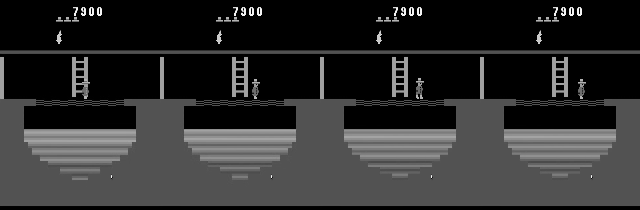

Go to the left side of the room 

Reality tells us its FALSE

Bimodal tells us its FALSE



stdin>  exit


In [24]:

# while (true)
#     IJulia.clear_output(true)
#     sample = rand(1:1:40)
    
#     f9=  first(dtst)[1][sample][1][:,:,1]
#     f4=  first(dtst)[1][sample][1][:,:,2]
#     f2=  first(dtst)[1][sample][1][:,:,3]
#     f1=  first(dtst)[1][sample][1][:,:,4]
    
    
#     both_frames = hcat(f9,f4,f2,f1)
    
#     img = Float32.(both_frames)

#     display(colorview(Gray, img))
    
#     for i in first(dtst)[1][sample][2]
#         for key in keys(wdict)
#             if i == wdict[key]
#                 if key == "<eos>"
#                     continue
                    
#                 end
#                 print(key)
#                 print(" ")
#             end
#         end
#     end
#     println()
#     println()
    
#     if first(dtst)[2][sample] == 1
#         println("Reality tells us its TRUE")
#     else
#         println("Reality tells us its FALSE")
#     end
#     println()
        
#     if argmax(convertsimilaritytoprobdist(b(first(dtst)[1]))[:,sample]) == 1
#         println("Bimodal tells us its TRUE")
#     else
#         println("Bimodal tells us its FALSE")
#     end
#         println()

# #     break
#     response = readline()
#     if (response == "exit")
#         break
#     end
    
    
# end

In [59]:
# for key in keys(wdict)
#     println(key)
#     println(wdict[key])
# end